1) Mounting google drive to google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2)Unzip GTSRB dataset

In [5]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/drive/MyDrive/GTSRB"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00010.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00011.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00012.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00013.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00014.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00015.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00016.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00017.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00018.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00019.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00020.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053_00021.png  
  inflating: /content/drive/MyDrive/GTSRB/train/5/00005_00053

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


3) Show some images of dataset

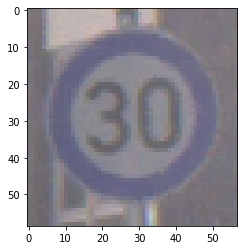

In [18]:
plt.figure(figsize = (4, 4))

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/drive/MyDrive/GTSRB/Train/1/00001_00000_00006.png")
plt.imshow(img)

4) Image Enhancement using imgaug library

In [39]:
#Image Enhancement using imgaug library
# (1): Image light and dark changes
# (2): Random Cropping and filling
# (3): Color Transformation

import random
import cv2
import glob
import imgaug.augmenters as iaa

# 1. Load dataset
images = []
images_path = glob.glob("/content/drive/MyDrive/GTSRB/Train/5/*.png")
for img_path in images_path:
  img = cv2.imread(img_path)
  images.append(img)

In [40]:
# 1. Image Light and Dark changes
number = random.randint(1,3)

if (number == 1):
  augmentation = iaa.Sequential([iaa.Multiply((0.8, 1.2))])
  # Multiply (make image brighter or darker)
  augmented_images = augmentation(images = images)

# 2.Random Cropping and filling
elif(number == 2):
  augmentation = iaa.Sequential([
      #Crop
      iaa.Crop(px = (0, 10), keep_size = False),
      #Fill
      iaa.Cutout(fill_mode="constant", cval=(0, 255), fill_per_channel=0.5)
  ])
  
  augmented_images = augmentation(images = images)

# 3.Color Transformation
else:
  augmentation = iaa.Sequential([
     iaa.AddToBrightness((-30, 30)),
     iaa.AddToHue((-50, 50)),

  ])
  
  augmented_images = augmentation(images = images)
  


In [41]:
image_no = 1
for img in augmented_images:

  name = "/content/drive/MyDrive/GTSRB/Train/5/img_" + str(image_no) + ".png"
  cv2.imwrite(name, img)
  image_no +=1

5)Reading the training data

In [43]:
import os
imgs_path = "/content/drive/MyDrive/GTSRB/Train"
data_list = []
labels_list = []
classes_list = 43

for i in range(classes_list):
  i_path = os.path.join(imgs_path, str(i)) #0-42
  for img in os.listdir(i_path):
    #open the image
    im = Image.open(i_path + '/' +img)
    #Resize the image to (32, 32)
    im = im.resize((32, 32))
    #Convert to numpy array
    im = np.array(im)
    #append to data_list
    data_list.append(im)
    labels_list.append(i)

data = np.array(data_list)
labels = np.array(labels_list)



In [44]:
data.shape

(51149, 32, 32, 3)

In [45]:
labels.shape

(51149,)

6)Preparing Dataset

In [46]:
def prep_dataset(X, y):
  #Convert from integers to floats
  X_prep = X.astype('float32')
  #normalize to the range 0-1
  X_prep /= 255.0
  y_prep = to_categorical(np.array(y))
  return (X_prep, y_prep)

X, y = prep_dataset(data, labels)

In [47]:
X.shape

(51149, 32, 32, 3)

In [48]:
y.shape

(51149, 43)

In [49]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, shuffle=True)


In [50]:
X_train.shape[1:]

(32, 32, 3)

7)Building the CNN model

In [55]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=3, activation='elu', padding='same', input_shape =X_train.shape[1:]))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=48, kernel_size=3, activation='elu', padding='same'))
model.add(layers.Conv2D(filters=48, kernel_size=3, activation='elu', padding='valid'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=96, kernel_size=3, activation='elu', padding='same'))
model.add(layers.Conv2D(filters=96, kernel_size=3, activation='elu', padding='valid'))
model.add(layers.AveragePooling2D(strides=2))

#Flatten
model.add(layers.Flatten())

#Dense layer with 384 hidden units
model.add(layers.Dense(384, activation='elu'))
#Softmax layer for output
model.add(layers.Dense(43, activation='softmax'))


In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 48)        6960      
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 48)        20784     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 48)         0         
 2D)                                                  

In [57]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])



In [58]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data= (X_val, Y_val))

Epoch 1/20
640/640 [==============================] - 149s 230ms/step - loss: 1.0631 - accuracy: 0.6794 - val_loss: 0.2757 - val_accuracy: 0.9146
Epoch 2/20
640/640 [==============================] - 140s 219ms/step - loss: 0.2328 - accuracy: 0.9222 - val_loss: 0.1490 - val_accuracy: 0.9546
Epoch 3/20
640/640 [==============================] - 130s 204ms/step - loss: 0.1424 - accuracy: 0.9509 - val_loss: 0.1031 - val_accuracy: 0.9685
Epoch 4/20
640/640 [==============================] - 131s 204ms/step - loss: 0.1114 - accuracy: 0.9605 - val_loss: 0.0888 - val_accuracy: 0.9697
Epoch 5/20
640/640 [==============================] - 136s 212ms/step - loss: 0.0995 - accuracy: 0.9639 - val_loss: 0.0659 - val_accuracy: 0.9760
Epoch 6/20
640/640 [==============================] - 130s 204ms/step - loss: 0.0899 - accuracy: 0.9671 - val_loss: 0.0785 - val_accuracy: 0.9742
Epoch 7/20
640/640 [==============================] - 130s 203ms/step - loss: 0.0854 - accuracy: 0.9699 - val_loss: 0.0730 -

In [59]:
model.predict(X_test)

160/160 [==============================] - 4s 27ms/step


array([[1.18527187e-21, 6.46861376e-31, 9.78171248e-28, ...,
        4.26949930e-29, 2.68280549e-28, 4.93537115e-30],
       [2.81040946e-20, 1.59453299e-12, 1.37862874e-10, ...,
        1.19433176e-20, 5.08157841e-22, 2.19429130e-13],
       [7.91662647e-09, 2.50054359e-01, 7.49559939e-01, ...,
        1.31029969e-08, 1.10698645e-10, 2.02606976e-09],
       ...,
       [0.00000000e+00, 1.54009921e-37, 0.00000000e+00, ...,
        2.30190814e-26, 3.10129470e-32, 2.20435460e-32],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.66832572e-18, 0.00000000e+00, ...,
        3.69106768e-30, 4.40141570e-37, 3.09277184e-35]], dtype=float32)

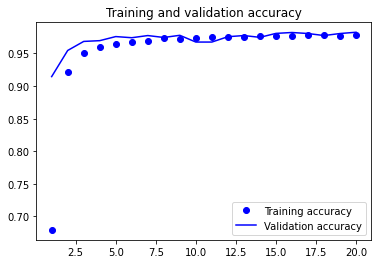

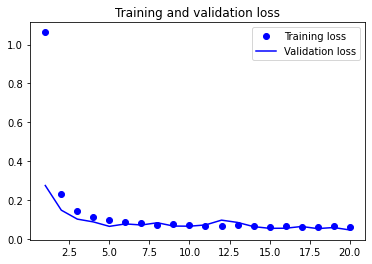

In [61]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()